# Distributed (Multi-function) Realtime Pipeline Example

Demonstrate how to run a pipeline which consists of multiple serverless functions (connected using streams).

In the pipeline example we accept a request containing a URL of a file, we load the content of the file and break it to words (using FlatMap class) and push the results to a queue/stream, the 2nd function picks up the words and add `Hello` to it and push the result to the output stream.  

**Setting the stream URLs for the internal queue, the final output and error/exceptions stream**

In [1]:
streams_prefix = "v3io:///users/admin/"
internal_stream = streams_prefix + "in-stream"
out_stream = streams_prefix + "out-stream"
err_stream = streams_prefix + "err-stream"

## Create The Pipeline

**Create a file with the graph steps (will be used in our pipeline):**

In [2]:
%%writefile steps.py
import mlrun
import json

# load struct from a json file (event points to the url)
def load_url(event):
    data = mlrun.get_object(event["url"])
    return json.loads(data)

# dummy print function
def myprint(x):
    print(x)
    return x

# function prefix the event with Hello
def add_hello(x):
    return f'Hello, {x}'

Overwriting steps.py


**Build and show the graph:**

In [ ]:
# set up the environment
import mlrun
from steps import *
mlrun.set_environment(project="pipe")

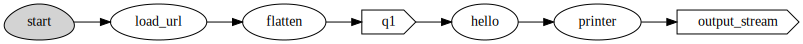

In [4]:
# define a new real-time serving function (from code) with an async graph
fn = mlrun.code_to_function("multi-func", filename="./steps.py", kind="serving", image='mlrun/mlrun:0.6.3-rc4')
graph = fn.set_topology("flow", engine="async")

# define the graph steps (DAG)
graph.to(name="load_url", handler="load_url")\
     .to("storey.FlatMap", "flatten", _fn="(event['words'])")\
     .to(">>", "q1", path=internal_stream)\
     .to(name="hello", handler="add_hello", function="enrich")\
     .to(name="printer", handler="myprint", function="enrich")\
     .to(">>", "output_stream", path=out_stream)

# specify the "enrich" child function, built from a notebook file
child = fn.add_child_function('enrich', './steps.py', 'mlrun/mlrun:0.6.3-rc4')

graph.plot(rankdir='LR')

## Test the pipeline with a local file

**Create an input file:**

In [5]:
%%writefile in.json
{"words": ["x", "y", "z", "w"]}

Overwriting in.json


**Create a mock server (simulator) and test:**

In [11]:
# tuggle verbosity if needed
fn.verbose = False

In [6]:
# create a mock server (simulator), specify we simulate all the functions in the pipeline ("*")
server = fn.to_mock_server(current_function="*")

In [7]:
# push a sample request into the pipeline and see the results print out (by our printer step)
resp = server.test(body={"url": "in.json"})

Hello, x
Hello, y
Hello, z
Hello, w


In [8]:
server.wait_for_completion()

## Deploy to the cluster

In [9]:
# add credentials to the data/streams
fn.apply(mlrun.platforms.v3io_cred())
child.apply(mlrun.platforms.v3io_cred())

# specify the error stream (will store exceptions from the functions)
fn.spec.error_stream = err_stream

# deploy as a set of serverless functions
fn.deploy()

> 2021-05-02 22:48:32,976 [info] deploy child function enrich ...
> 2021-05-02 22:48:32,996 [info] Starting remote function deploy
2021-05-02 22:48:33  (info) Deploying function
2021-05-02 22:48:33  (info) Building
2021-05-02 22:48:33  (info) Staging files and preparing base images
2021-05-02 22:48:33  (info) Building processor image
2021-05-02 22:48:46  (info) Build complete
2021-05-02 22:48:52  (info) Function deploy complete
> 2021-05-02 22:48:52,767 [info] function deployed, address=default-tenant.app.yh30.iguazio-c0.com:32072
> 2021-05-02 22:48:52,768 [info] deploy root function multi-func ...
> 2021-05-02 22:48:52,769 [info] Starting remote function deploy
2021-05-02 22:48:52  (info) Deploying function
2021-05-02 22:48:52  (info) Building
2021-05-02 22:48:52  (info) Staging files and preparing base images
2021-05-02 22:48:52  (info) Building processor image
2021-05-02 22:48:56  (info) Build complete
2021-05-02 22:49:02  (info) Function deploy complete
> 2021-05-02 22:49:03,082 [i

'http://default-tenant.app.yh30.iguazio-c0.com:32046'

**Test the live function**
> Note: the url need to be a valid path to the input file

In [13]:
fn.invoke('', body={"url": "v3io:///users/admin/in.json"})

{'id': '9e7ec442-5437-4491-b903-4ca827cec472'}